# Object masks in images from prompts with SAM 2

In [1]:
from mask_maker import *

In [10]:
# INPUTS
path_1 = "./BDD/Reel/Buddha_1/Stray/DSC_9535.NEF"
stray = load_image(path_1, 1)

path_2 = "./BDD/Reel/Buddha_1/Stray&PS/DSC_9536.NEF"
light_p_stray = load_image(path_2, 1)

light = light_p_stray - stray


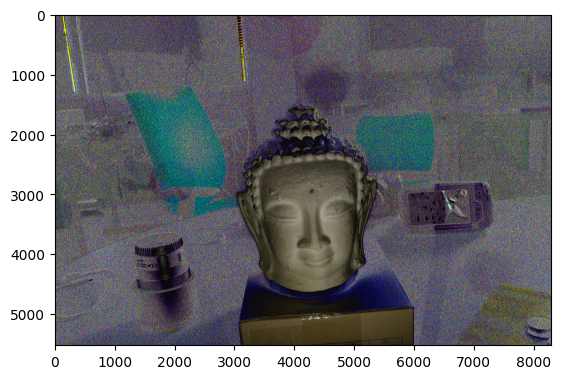

In [11]:
plt.imshow(light)